<a href="https://colab.research.google.com/github/vilsaira/example/blob/main/MATRENA_014_dMRI_ADC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Laskuharjoitus diffuusiopainotetusta magneettikuvantamisesta (dMRI)

Näennäinen diffuusiovakio (apparent diffusion coefficient, ADC) mahdollistaa mm. aivoinfarktin varhaisen havaitsemisen, joka on eduksi potilaan elämänlaatua ja ajatellen. Aivoinfarkteissa oleellista on olla nopea, joten lyhyet kuvausajat ovat eduksi. Mielenkiintoiseksi ADC:n tekee se, että sitä ei mitata suoraan vaan se on laskennallinen kuva, joka perustuu dMRI-kuvaukseen.
Taustatietona tehtävään on tietenkin oppikirja, mutta lisäksi Siemensin julkaisema white paper, joka kertoo kuinka ADC heidän mielestään tulisi määrittää [Sic]. Linkki julkaisuun on tässä http://clinical-mri.com/wp-content/uploads/software_hardware_updates/Graessner.pdf.

Siemensin julkaisussa on vähintään yksi virheellinen suositus. Tehtäväsi on löytää ja korjata se. Virheen osoittamiseen voit halutessasi hyödyntää alla olevasta taulukosta löytyviä dMRI-mittapisteitä.

Taulukko sisältää mittauksissa käytetyt diffuusiopainotukset eli b-arvot sekä vastaavat ”todelliset” mittaustulokset eli signaalit. Tosimaailmassa mittaustuloksissa on kuitenkin kohinaa ja siksi mittaus on toistettu kolmeen kertaan. Tässä esimerkissä signaalikohinasuhde (SNR) on huomattavasti todellisuutta pienempi, jotta sen vaikutus on helpommin havaittavissa. Voit kuvitella, että nämä signaalit ovat mitattu yhdestä kuva-alkiosta (voxelista) dMRI-kuvissa. Mittaustuloksen yksiköillä ei ole merkitystä tässä tapauksessa.

ADC voidaan ratkaista taulukosta yhtälön $S_{b>0}=S_{b=0}⋅e^\left(-b⋅ADC\right)$ avulla eli sovittamalla dataan eksponenttifunktion. Tapoja funktiosovituksiin on monia ja siksi ratkaisutapa on vapaa. Numeerinen ratkaisu perustuen joko annettuun taulukkoon tai muuhun mielekkääseen simulaatioon hyväksytään. Jos saat käsiisi jostain tehtävään sopivaa dMRI-dataa, niin senkin käyttö on hyväksyttävää, mutta ei edellytys. Ratkaisu on myös mahdollista tehdä puhtaan teoreettisesti, sillä tämä on niitä harvoja käytännön ongelmia, joilla on myös analyyttinen ratkaisu!

Vinkki 1: Löydettävä virhe liittyy julkaisun kappaleisiin “**Why should I measure three b-values for a DWI protocol when two would be enough for calculating ADC?**” ja “**How is the ADC calculated?**”.


# Ratkaisu

Ladataan ensin tarpeelliset Python kirjastot

In [ ]:
import numpy as np # matriisilaskenta
import matplotlib.pyplot as plt # kuvien plottaus

Seuraavaksi tallennetaan tehtävässä käytettävät mittaukset Numpy-taulukkoon ongelman ratkaisemiseksi.

In [ ]:
# b-arvot eli diffuusiopainotus
b = np.array([0, 0, 0, 0.5, 0.5, 0.5, 1.0, 1.0, 1.0])
# todelliset signaaliarvot
signal = np.array([1000, 1000, 1000, 640.8243, 640.8243, 640.8243, 410.6558, 410.6558, 410.6558])
# kohinainen signaali
noisy_signal = np.array([1027.024, 1121.748, 860.6646, 556.1274, 352.9507, 485.3491, 543.4734, 476.9008, 248.9531])

Tarkastellaan miltä mittaukset näyttävät.

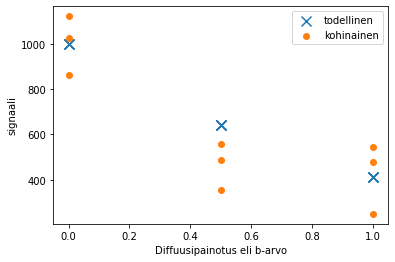

In [ ]:
plt.scatter(b, signal, label = 'todellinen', marker='x', s=100)
plt.scatter(b, noisy_signal, label = 'kohinainen')
plt.xlabel("Diffuusipainotus eli b-arvo")
plt.ylabel("signaali")
plt.legend()

Siemensin julkaisun perusteella ADC lasketaan log-linearisoinnin avulla, joten katsotaan, miltä mittaukset näyttävät muunnoksen jälkeen.

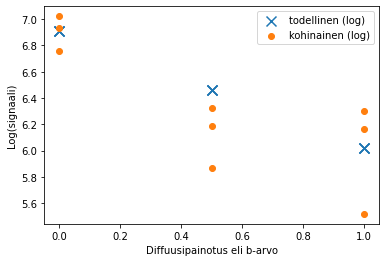

In [ ]:
log_signal = np.log(signal) # Numpyn log() luonnollinen logaritmi eli esim. Excelin LN()
log_noisy_signal = np.log(noisy_signal)
plt.scatter(b, log_signal, label = 'todellinen (log)', marker='x', s=100)
plt.scatter(b, log_noisy_signal, label = 'kohinainen (log)')
plt.xlabel("Diffuusipainotus eli b-arvo")
plt.ylabel("Log(signaali)")
plt.legend()

Sovitetaan log-lineaariseen dataan suora käyttäen kaikkia mittapisteitä.

Lineaarinen systeemi $\mathbf{y}=\beta_0 + \beta_1 \cdot \mathbf{x} + \mathbf{\epsilon}$ voidaan esittää matriisimuodossa
$\mathbf{y} = \mathbf{X}\beta+ \mathbf{\epsilon}$, jolloin ongelman parametrit $\beta$ voidaan ratkaista esimerkiksi pienimmän neliösumman menetelmällä minimoimalla $S\left(\beta\right)=||\mathbf{y} - \mathbf{X}\beta||^2$.

$$ \mathbf{y} = \mathbf{X}\beta $$
$$ \mathbf{X}^{\top}\mathbf{y} = \mathbf{X}^{\top}\mathbf{X}\beta $$
$$ \hat{\beta} = \left(\mathbf{X}^{\top}\mathbf{X}\right)^{-1} \mathbf{X}^{\top}\mathbf{y} $$

In [ ]:
# Lineaarisen ongelman suunnittelumatriisi X
N = len(noisy_signal) # Mittapisteiden lukumäärä (9)
X = np.ones((N,2))
X[:,1] = b
print(X)

[[1.  0. ]
 [1.  0. ]
 [1.  0. ]
 [1.  0.5]
 [1.  0.5]
 [1.  0.5]
 [1.  1. ]
 [1.  1. ]
 [1.  1. ]]


Lineaarisen ongelman parametrien ratkaisu. Tämä siis käyttäen kohinaisen signaalin logaritmia.

In [ ]:
beta = np.linalg.pinv(X.T @ X) @ X.T @ log_noisy_signal
print(f"leikkauspiste (beta0) = {beta[0]}")
print(f"ADC eli kulmakerroin (beta1) = {beta[1]}")

leikkauspiste (beta0) = 6.796426625245378
ADC eli kulmakerroin (beta1) = -0.9107383768929909


Verrataan mittaustuloksiin graafisesti.

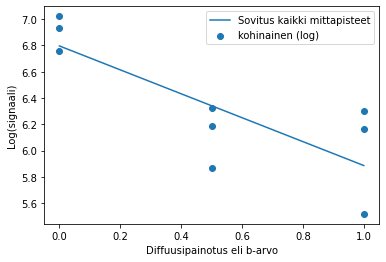

In [ ]:
t = np.array([0,1])
y = beta[0] + beta[1] * t
plt.scatter(b, log_noisy_signal, label = 'kohinainen (log)')
plt.plot(t, y, label = 'Sovitus kaikki mittapisteet')
plt.xlabel("Diffuusipainotus eli b-arvo")
plt.ylabel("Log(signaali)")
plt.legend()

Toiveena oli, että tähän kuvaajaan asti olisi päässyt. Arvot oli valittu siten, että kuvaajan **kiikkulauta** toimisi jatkovihjeenä. Mitä tapahtuu, jos kiikkulautaa (tai vaakaa) nostaa sen keskiakselista? Tai laskee? Muuttuuko kulmakerroin (siis ADC)?

Lasketaanpa huvin ja urheilun vuoksi ADC uudelleen, mutta jätetään keskimmäiset mittapisteet käyttämättä. Elegantti tapa suorittaa tämä, on käyttää painotettua pienimmän neliösumman menetelmää ja laskea $b=0.5$ mittapisteiden paino nollaksi. Minimoidaan siis  
$$S\left(\beta\right) = ||\mathbf{W}^{\frac{1}{2}}\left(\mathbf{y} - \mathbf{X}\beta\right)||^2$$,
mistä saadaan parametrit ratkaistua seuraavasti
$$ \hat{\beta} = \left(\mathbf{X}^{\top} \mathbf{W} \mathbf{X}\right)^{-1} \mathbf{X}^{\top} \mathbf{W} \mathbf{y} $$

Asettamalla $b=0.5$ painoarvot nolliksi, vastaa tilannetta, missä kyseiset mittauksen otettaisiin kokonaan pois log_noisy_signal ja $\mathbf{X}$ matriiseista.

In [ ]:
weights = np.array([1,1,1,0,0,0,1,1,1]) # painoarvot
W = np.diag(weights) # Matriisilaskenta-algoritmit edellyttävät neliömatriisia.
# Tämä ei ole usein optimaalinen tapa, jos mittapisteitä on paljon, koska matriisi W on suurimmaksi osaksi nollia täynnä.
beta_w = np.linalg.pinv(X.T @ W @ X) @ X.T @ W @ log_noisy_signal
print(f"leikkauspiste (beta_w0) = {beta_w[0]}")
print(f"ADC eli kulmakerroin (beta_w1) = {beta_w[1]}")
print(f"ADC arvojen ero {beta[1] - beta_w[1]}")

leikkauspiste (beta_w0) = 6.904922974037941
ADC eli kulmakerroin (beta_w1) = -0.9107383768929851
ADC arvojen ero -5.773159728050814e-15


Ero aiempaan ADC arvoon on siis luokkaa $10^{-15}$ eli menee numeerisen epätarkkuuden piiriin! Keskimmäisten mittapisteiden vaikutus kulmakertoimeen näyttäisi empiirisesti olevan häviävän pieni.

Ehkä huijasin teitä, ja tein jotain kavalaa tuon painotetun ratkaisun kanssa. Joten tarkistetaanpa asia muuttamalla alkuperäisiä log_noisy_signal tuloksia hieman.

In [ ]:
log_noisy_signal_sic = log_noisy_signal.copy()
log_noisy_signal_sic[3:6] = 10 # Asetetaan kaikki b=0.5 mittaukset arvoltaan kymmeneksi.
beta_sic = np.linalg.pinv(X.T @ X) @ X.T @ log_noisy_signal_sic
print(f"leikkauspiste (beta0) = {beta_sic[0]}")
print(f"ADC eli kulmakerroin (beta1) = {beta_sic[1]}")

leikkauspiste (beta0) = 8.088405045507459
ADC eli kulmakerroin (beta1) = -0.9107383768929918


Kulmakerroin on edelleen sama! Plotataanpa aiempi suora ja tämä viimeisin vierekkäin:

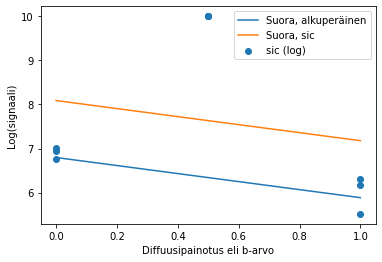

In [ ]:
t = np.array([0,1])
y = beta[0] + beta[1] * t
y_sic = beta_sic[0] + beta_sic[1] * t
plt.scatter(b, log_noisy_signal_sic, label = 'sic (log)')
plt.plot(t, y, label = 'Suora, alkuperäinen')
plt.plot(t, y_sic, label = 'Suora, sic')
plt.xlabel("Diffuusipainotus eli b-arvo")
plt.ylabel("Log(signaali)")
plt.legend()

Eli näyttäisi siltä, että ADC ei tosiaan riipu lainkaan keskimmäisestä mittapisteestä. Tälle on paljon hyviä analogioita kiikkukeinun lisäksi, esim. vipuvarsi. Mitä kauempana mittapiste on janan keskipisteestä, sitä suurempi painoarvo sillä on kulmakertoimeen. Keskellä olevan mittapisteen painoarvo sen sijaan on nolla. **Tälle on analyyttinen ratkaisukin!**

Suoran sovituksessa kulmakerroin (ADC) $n$ mittapisteestä voidaan ratkaista seuraavasta yhtälöstä {Linear Regression and Correlation. Kenney 1962}:

$$ADC = \frac{\sum_{i=1}^{n} \left(x_i - \overline{x} \right) \left(y_i - \overline{y} \right)} {\sum_{i=1}^{n} \left(x_i - \overline{x} \right)^2} \tag{1},$$

missä $\overline{y}$ on mitta-arvojen keskiarvo ja $\overline{x}$ on mittapisteiden keskiarvo. Kuvitellaan, että meillä on yksi mittapiste $x_m=\overline{x}$, jonka arvo on $y_m$.  Yhtälössä (1) ainoastaan nimittäjä riippuu arvosta $y_m$, joten tarkastellaan vain sitä ja irroitetaan tämä keskimääräinen mittapiste $m$ summasta:

$$ \sum_{i=1}^{n} \left(x_i - \overline{x} \right) \left( y_i - \overline{y} \right) = \left(x_m - \overline{x} \right) \left(y_m - \overline{y} \right) + \sum_{i=1,i\neq m}^n \left(x_i - \overline{x} \right) \left( y_i - \overline{y} \right) \tag{2} $$

Yhtälön 2 oikean puolen ensimmäinen termi on nolla, koska valittu mittapiste $x_m = \overline{x}$. Jäljelle jäävässä summatermissä ainoastaan mittapisteiden keskiarvo $\overline{y}$ voisi olla riippuvainen mitta-arvosta ${y_m}$. Lavennetaan yhtälön 2 summatermi:

$$ \sum_{i=1,i\neq m}^n \left(x_i - \overline{x} \right) \left( y_i - \overline{y} \right) = x_i y_i - \overline{x}y_i - x_i \overline{y} + \overline{x}\overline{y} = x_i y_i - \overline{x}y_i + \left(\overline{x} - x_i \right)\overline{y} \tag{3} $$

Ainoastaan viimeinen termi yhtälössä 3 voisi olla riippuvainen mittapisteestä $y_m$, joten lavennetaan sitä edelleen.

$$ \sum_{i=1,i\neq m}^n \left(\overline{x} - x_i \right) = \left(n-1\right)\overline{x} - \sum_{i=1,i\neq m}^n x_i = \left(n-1\right)\overline{x} - \left( \sum_{i=1}^n x_i -x_m \right) = \left(n-1\right)\overline{x} - \left( n \frac{1}{n} \sum_{i=1}^n x_i -x_m \right) \tag{4} $$

Mittapiste $x_m = \overline{x}$ ja keskiarvo $\frac{1}{n}\sum_{i=1}^{n} x_i = \overline{x}$. Sijoitetaan nämä yhtälöön 4 ja lavennetaan.

$$ \left(n-1\right)\overline{x} - \left( n \frac{1}{n} \sum_{i=1}^n x_i -x_m \right) = \left(n-1\right)\overline{x} - \left( n\overline{x} - x_m \right) = n\overline{x} - \overline{x} - n\overline{x} + x_m = 0$$

Eli keskimääräinen mitta-arvo $y_m$ kerrotaan nollalla! Kulmakerroin ei siis voi riippua lainkaan tästä mittapisteestä. Sijoitetaan vielä nämä kaikki välivaiheet yhtälöön 1:

$$ ADC = \frac{\sum_{i=1}^{n} \left(x_i - \overline{x} \right) \left(y_i - \overline{y} \right)} {\sum_{i=1}^{n} \left(x_i - \overline{x} \right)^2} = \frac{\sum_{i=1,i\neq m}^n \left(x_i y_i - \overline{x} y_i \right)} {\sum_{i=1}^{n} \left(x_i - \overline{x} \right)^2} \tag{6} $$

Sijoittamalla esimerkin arvot yhtälöön 6 saadaan ADC:n arvoksi sama kuin lineaarisen regression numeerisella ratkasulla.

In [ ]:
# Lasketaan ADC yhtälön 6 avulla
# x-akseli on b-arvot
# y-akseli on log_noisy_signal

x = b
x_m = np.average(x)
y = log_noisy_signal

A = 0
B = 0
for i in range(N):
  if not (x[i] == x_m):
    A += (x[i] * y[i]) - (x_m * y[i])
    B += (x[i] - x_m)**2

ADC = A/B
print(f"Suoran sovitus kaikkiin mittapisteisiin, ADC = {beta[1]}")
print(f"Painotettu suoran sovitus, ADC_w = {beta_w[1]}")
print(f"Analyyttinen ratkaisu, ADC = {ADC}")

Suoran sovitus kaikkiin mittapisteisiin, ADC = -0.9107383768929909
Painotettu suoran sovitus, ADC_w = -0.9107383768929851
Analyyttinen ratkaisu, ADC = -0.9107383768929868


Yhteenveto: Siemensin suositus on matematiikan vastainen ja johtaa joko pidempään kuvausaikaan tai huonompaan kuvanlaatuun, kuin loogisesti valittu sekvenssi tuottaisi. Valitettavasti tämä suositus on levinnyt laajalle, koska suoran sovitus on ilmeisesti hankala asia. Esimerkiksi, ACR PI-RADS (American College of Radiologi, Prostate Imaging Reporting & Data System) suositus on käyttää juurikin samanlaista kuvausta ja tämä on otettu käyttöön myös HUS:ssa käyttäen useita b=mean(b) arvoja. **Tämä pidentää potilaskohtaista kuvausaikaa minuutista kahteen turhaan lukuisissa kliinissä protokollissa ilmeisesti kautta maailman.** 